# Problem Statement

Pneumonia is a serious respiratory infection that affects millions of people worldwide, particularly children and the elderly. Early and accurate diagnosis is critical for effective treatment and preventing severe complications. Currently, diagnosing pneumonia often relies on medical imaging techniques like chest X-rays, which are then interpreted by radiologists. However, the interpretation of X-rays can be challenging and subject to inter-observer variability, especially in resource-limited settings where access to experienced radiologists may be limited. There is a need for automated or semi-automated tools that can assist in the timely and accurate detection of pneumonia from chest X-rays.

We selected a dataset from Kaggle featuring 5,863 chest x-ray images from patients being seen for pneumonia, in order to see if we could train a model to accurately diagnose pneumonia based on a single x-ray.

# Justification for the Proposed Approach

Our proposed approach leverages the power of deep learning, speciallyu Convolution Neural Network (CNNs), to automate the process of identifying pneumonia in X-rays. CNNs have demonstrated remarkable success in image recognition tasks, including medical image analysis.

*   Feature Engineering - CNNs can automatically learn hierarchical features directly from the raw image data, which are required for identifying the complex patterns associated with pnemonia from chest X-ray. This elimitaes the need for feature engineering.
*   Addressing Data Limitations - Medical imaging datasets can be limited in size due to privacy concerns and the cost of data collection. Data augmentation helps to artificially expand the effective size of the training dataset, reducing the risk of overfitting and improving the model's ability to generalize to unseen data.
*   Potential automation - A trained CNN model could be deployed aiding rapid prediction, potentially assisting healthcare professionals in making quicker detection.
By developing a CNN-based classifier, we aim to provide a tool that can complement the work of medical professionals, potentially leading to earlier detection.






# Image Preprocessing for Pneumonia Classification

[Open in Colab](https://colab.research.google.com/github/omarsagoo/AI-pneumonia-classifier/blob/main/notebooks/preprocessing.ipynb)

This section of the notebook handles image loading, preprocessing, and augmentation for the chest X-ray dataset used in the pneumonia classification project.

## Objectives

- Load and inspect raw X-ray images
- Normalize image dimensions and pixel intensities
- Apply grayscale conversion
- Perform data augmentation to reduce overfitting
- Prepare data generators for model training and evaluation

# Data Understanding

## Install Dependecies and Import Required Packages

In [5]:
pip install tensorflow

In [6]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Import utility functions

from utils.preprocessor import show_sample_images, visualize_augmentation

## Directory Structure

Define paths to the training, validation, and test datasets.

In [9]:
base_dir = '/content/drive/MyDrive/AI-pneumonia-classifier/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Visual Inspection of Images

Display a few sample images from each class to understand dataset characteristics.


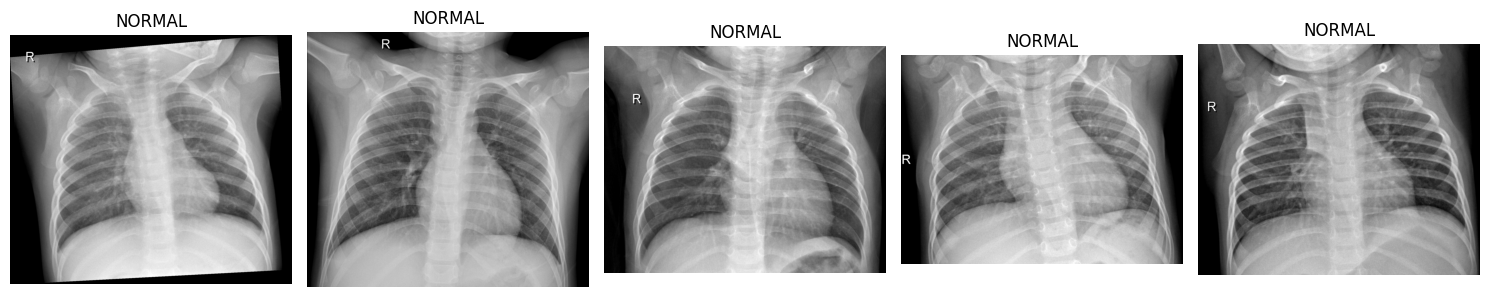

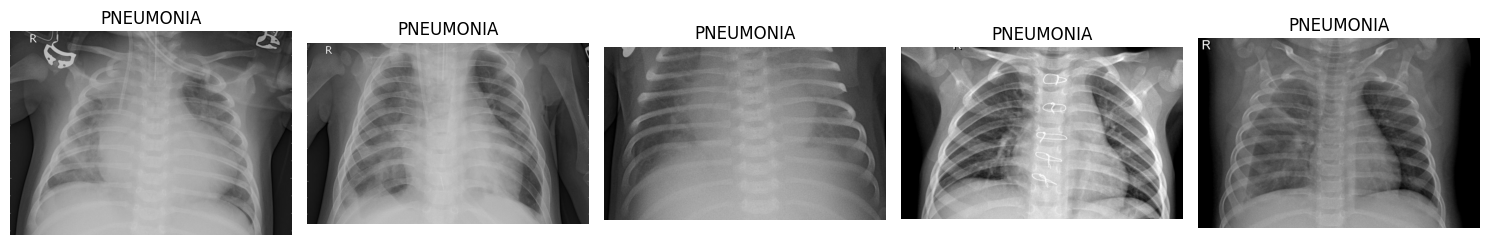

In [10]:
# Visualize normal and pneumonia samples
show_sample_images(train_dir, 'NORMAL')
show_sample_images(train_dir, 'PNEUMONIA')

# Data Preparation

## Data Preprocessing and Augmentation

To mitigate overfitting and simulate real-world variability in medical imaging, we apply a variety of computer vision augmentation techniques during training, including:

- Horizontal flipping
- Random cropping (via width and height shift)
- Rotation
- Zoom
- Brightness adjustment
- Shearing

All pixel values are rescaled to the [0, 1] range.

Medical imaging datasets are often limited in size and diversity due to patient privacy, cost, and availability. Data augmentation is a critical technique to increase the effective size of the dataset and improve model generalization.

For pneumonia detection from chest X-rays, augmentation serves several purposes:

- **Horizontal flipping** simulates anatomical variation and positional differences between left and right lungs.
- **Cropping and shifting** emulate differences in patient positioning and framing.
- **Brightness adjustments** reflect variability in exposure across X-ray machines.
- **Rotation and shear** simulate variations due to imperfect alignment of patients during scanning.
- **Zoom and scaling** improve the model’s ability to recognize pneumonia patterns at different resolutions.

These augmentations help the model learn invariant and robust features, reducing overfitting and improving performance on unseen data.

In [11]:
IMG_SIZE = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,             # Random rotation between -15 to 15 degrees
    width_shift_range=0.1,         # Horizontal shift
    height_shift_range=0.1,        # Vertical shift
    zoom_range=0.1,                # Random zoom
    shear_range=0.1,               # Shear angle
    horizontal_flip=True,          # Random horizontal flipping
    brightness_range=[0.8, 1.2]    # Random brightness adjustment
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 5243 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


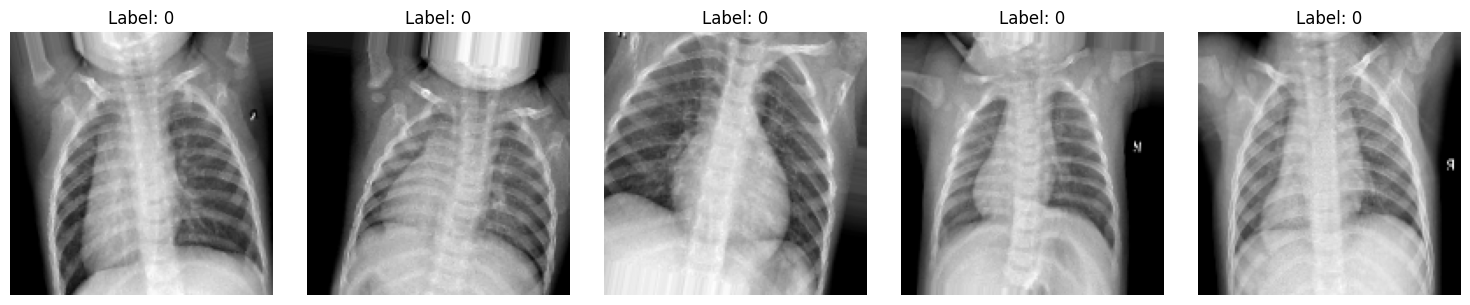

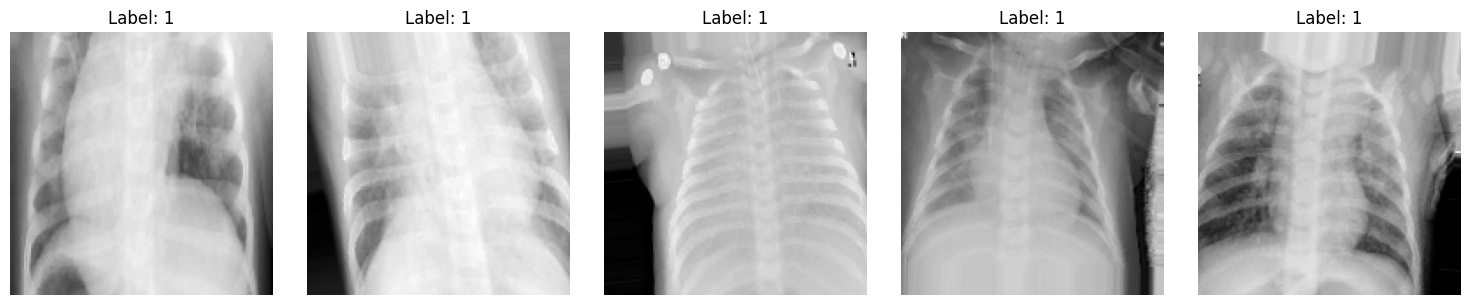

In [12]:
# Show examples of augmented 'NORMAL' (label 0) and 'PNEUMONIA' (label 1)
visualize_augmentation(train_generator, class_label=0, num_images=5)
visualize_augmentation(train_generator, class_label=1, num_images=5)

# Build the CNN

In this section, we will focus on developing, evaluating, and refining our deep learning model for pneumonia detection. We will begin by defining our initial Convolutional Neural Network (CNN) architecture, train it, and evaluate its performance. Following this, we will explore techniques to improve the model's accuracy and generalization, including hyperparameter tuning and addressing potential issues like overfitting and class imbalance.

## Define the CNN Model Architecture

We will start with a relatively simple yet effective CNN architecture. This architecture consists of convolutional layers for feature extraction, pooling layers for down-sampling, and dense layers for classification. We've chosen this architecture as a baseline due to CNNs' proven success in image recognition tasks.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5), # Dropout for regularization
        Dense(1, activation='sigmoid') # Output layer for binary classification
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile the Model

Before training, we need to compile the model by specifying the optimizer, loss function, and evaluation metrics. We will use the Adam optimizer, binary cross-entropy loss (appropriate for binary classification), and track accuracy, precision, and recall to assess performance.

In [14]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)

## Train the Model

We will train the initial model using the prepared training data generators. We will monitor performance on the validation set during training to get an early indication of how well the model is generalizing.


Train the model using the data generators created in preprocessing steps

In [15]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10, #epochs set to 10 for now
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 856s 5s/step - accuracy: 0.7242 - loss: 0.5946 - precision: 0.7387 - recall: 0.9692 - val_accuracy: 0.7500 - val_loss: 0.7486 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - accuracy: 0.8125 - loss: 0.3109 - precision: 0.8462 - recall: 0.9167

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.3109 - precision: 0.8462 - recall: 0.9167 - val_accuracy: 0.7500 - val_loss: 0.6971 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8454 - loss: 0.3085 - precision: 0.8698 - recall: 0.9346 - val_accuracy: 0.7500 - val_loss: 0.6115 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.2580 - precision: 0.9500 - recall: 0.8261 - val_accuracy: 0.8750 - val_loss: 0.6315 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8879 - loss: 0.2718 - precision: 0.9058 - recall: 0.9501 - val_accuracy: 0.8125 - val_loss: 0.6120 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2046 - precision: 0.9565 - recall: 0.9167 - val_accuracy: 0.7500 - val_loss: 0.6699 - va

## Initial Model Evaluation and Analysis

After the initial training, we will evaluate the model on the independent test set to get an unbiased assessment of its performance. We will analyze the key metrics (loss, accuracy, precision, recall) to understand the model's strengths and weaknesses.

In [16]:
loss, acc, prec, rec = model.evaluate(test_generator)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.6432 - loss: 0.8258 - precision: 0.3991 - recall: 0.6521
Loss:  0.48711293935775757
Accuracy:  0.8012820482254028
Precision:  0.7692307829856873
Recall:  0.9743589758872986


### Analyzing Initial Performance Using Confusion Matrix

To gain deeper insights into the model's performance, we will visualize the confusion matrix. This will help us understand the types of errors the model is making, specifically the number of false positives and false negatives, which are crucial in a medical diagnostic context.

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step


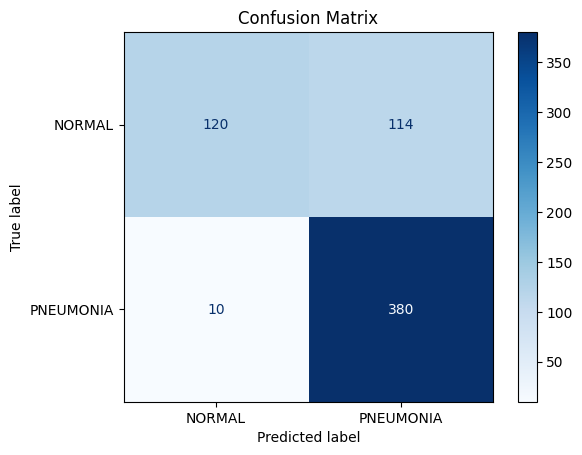

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get predictions and true labels
test_predictions = model.predict(test_generator)
test_true_labels = test_generator.classes

# Convert probabilities to binary predictions (0 or 1)
test_pred_labels = (test_predictions > 0.5).astype(int)

# Calculate the confusion matrix

cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



# Finetune the model

Based on the initial evaluation and confusion matrix analysis, we will now implement strategies to improve the model's performance and address potential issues like overfitting and class imbalance. We will focus on adding more regularization through dropout layers, employing early stopping during training, and using class weights to handle the data imbalance.
We have already added one dropout layer in our initial model. Now we can add more dropout layers after other layers to further regularize the model.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added Dropout layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added Dropout layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added Dropout layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Implement Early Stopping

create an EarlyStopping instance and include it in the callbacks argument of model.fit() call.

In [16]:
# Define the EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

### Address Data Imbalance with Class Weights:

Class imbalance can lead to a model that is biased towards the majority class. We can address this by assigning higher weights to the samples of the minority class during the training.

In [17]:
from sklearn.utils import class_weight

# Get class labels and counts from the training generator
class_labels = list(train_generator.class_indices.keys())
class_counts = np.bincount(train_generator.classes)

# This function automatically calculates weights such that the total weight of each class is balanced.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

print("Class labels:", class_labels)
print("Class counts:", class_counts)
print("Class weights:", class_weights_dict)

Class labels: ['NORMAL', 'PNEUMONIA']
Class counts: [1359 3884]
Class weights: {np.int32(0): np.float64(1.9289919058130978), np.int32(1): np.float64(0.6749485066941298)}


In [19]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict  # Add class weights
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 404ms/step - accuracy: 0.4826 - loss: 0.7005 - precision: 0.7893 - recall: 0.4068 - val_accuracy: 0.4375 - val_loss: 0.6899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.6106 - precision: 0.9167 - recall: 0.4231 - val_accuracy: 0.4375 - val_loss: 0.6825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 385ms/step - accuracy: 0.7165 - loss: 0.5287 - precision: 0.9052 - recall: 0.6914 - val_accuracy: 0.8750 - val_loss: 0.5365 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.3278 - precision: 1.0000 - recall: 0.7778 - val_accuracy: 0.8750 - val_loss: 0.5321 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 386ms/step - accuracy: 0.8393 - loss: 0.3612 - precision: 0.9476 - recall: 0.8303 - val_accuracy: 0.9375 - val_loss: 0.4991 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2912 - precision: 0.9600 - recall: 0.9231 - val_accuracy: 0.9375 - val_loss: 0.5053 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 369ms/step - accuracy: 0.8597 - loss: 0.3247 - precision: 0.9545 - recall: 0.8518 - val_accuracy: 0.6875 - val_loss: 0.66

## Evaluation and Analysis of the Fine-tuned Model

After training the fine-tuned model, we will evaluate it on the test set and compare its performance to the initial model.

In [21]:
loss, acc, prec, rec = model.evaluate(test_generator)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7100 - loss: 0.5446 - precision: 0.4310 - recall: 0.6436
Loss:  0.37215617299079895
Accuracy:  0.8221153616905212
Precision:  0.8052516579627991
Recall:  0.9435897469520569


### Confusion Matrix for the Fine-tuned Model

We will plot the confusion matrix for the fine-tuned model to understand how the tuning techniques have impacted the types of errors.

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step


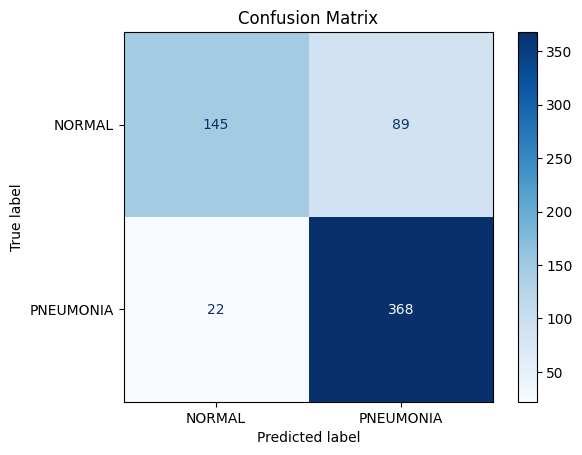

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get predictions and true labels
test_predictions = model.predict(test_generator)
test_true_labels = test_generator.classes

# Convert probabilities to binary predictions (0 or 1)
test_pred_labels = (test_predictions > 0.5).astype(int)

# Calculate the confusion matrix

cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Evaluation - Performance conparison, Result Analysis and Conclusion

After training both the initial and fine-tuned CNN models, we evaluated their performance on the independent test set to assess their ability to generalize to unseen data. We used the following performance measures:

Loss: The loss on the test set decreased from 0.4871 to 0.3722 after tuning. This indicates that the fine-tuned model has a lower error rate and is a better fit for the test data compared to the initial model.

Accuracy - Although there is not a substantial increase in the accuracy.

Precision - Precision increased, it is more likely to be correct (fewer false positives). This is particularly important in a medical setting where a false positive could lead to unnecessary further tests or treatment.

Recall - Recall slightly decreased from 0.9744 to 0.9436. This suggests that the fine-tuned model misses a few more actual pneumonia cases compared to the initial model (slightly more false negatives). However, a recall of over 94% is still very high and indicates that the model is still very good at identifying pneumonia cases.

Overall Conclusion -

The fine-tuning techniques implemented were effective in improving the model's overall performance. The decrease in loss and increase in accuracy and precision are positive signs. While there was a slight trade-off in recall, the increase in precision is significant and valuable for a diagnostic tool. The fine-tuned model demonstrates a better balance between identifying pneumonia cases and minimizing false positives.

Based on the evaluation results, the fine-tuned model is a better performing model for this task. However, there is still room for further improvement. Here are some actionable insights and recommendations:

1. Investigate the False Negatives -  Although recall is high, understanding the characteristics of the few false negatives (actual pneumonia cases missed by the model) could provide insights into potential model weaknesses or difficult cases. Analyzing these images might suggest further data augmentation strategies or architectural modifications.

2. Hyperparameter Tuning - While early stopping and dropout were used, a more extensive hyperparameter search like grid searcg or random search for learning rate, batch size, and dropout rates could further optimize the model.

3. Given the medical context of this problem, where high confidence in predictions is crucial, exploring ensembles could be a valuable next step to reduce prediction variance and potentially capture more complex patterns. Due to computational constraints in a typical notebook environment, implementing and thoroughly evaluating complex ensembles might be beyond the scope of this specific notebook, but it is a strong recommendation for future work. If resources permit, we could train multiple variations of our fine-tuned CNN or even different model architectures and combine their predictions.


